<a href="https://colab.research.google.com/github/cmannnn/predict_future_sales/blob/main/predict_future_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Future Sales

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

# File descriptions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

itemcats_df - supplemental information about the items categories.

items_df - supplemental information about the items/products.

salestrain_df - the training set. Daily historical data from January 2013 to October 2015.

shops_df - supplemental information about the shops.

test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.

sample_submission.csv - a sample submission file in the correct format.

# Imports and uploads

In [ ]:
# imports
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

import datetime as dt

#import specific sklearn packages
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import StratifiedKFold

#encoders, tested several of them
from sklearn.preprocessing import OrdinalEncoder # remove later, don't use this
from sklearn.preprocessing import LabelEncoder # remove later, don't use this
from sklearn.preprocessing import OneHotEncoder # probably don't use this, instead use pd.get_dummies
from sklearn.feature_extraction import FeatureHasher

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import VarianceThreshold

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.pipeline import make_pipeline

from sklearn.cluster import KMeans

from sklearn.linear_model import LogisticRegression

from sklearn import linear_model

from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor

from tensorflow import keras
from keras import backend as K
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.losses import mean_squared_error

## Kaggle Imports 

In [ ]:
#!pip install kaggle

In [ ]:
# UPLOAD YOUR kaggle.json KEY HERE

# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#  print('User uploaded file "{name}" with length {length} bytes'.format(
#      name=fn, length=len(uploaded[fn])))


#!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# !kaggle competitions list

In [ ]:
# !mkdir -p predict_future_sales

In [ ]:
# UPLOAD 6 FILES HERE
# uploaded2 = files.upload()

In [ ]:
#!cp test.csv predict_future_sales/
#!cp item_categories.csv predict_future_sales/
#!cp items.csv predict_future_sales/
#!cp sales_train.csv predict_future_sales/
#!cp sample_submission.csv predict_future_sales/
#!cp shops.csv predict_future_sales/
#!cp test.csv predict_future_sales/

# Importing All Predict Sales Data

In [ ]:
#importing all the data frames
root_path='drive/MyDrive/Camp Jupyter/predict_future_sales_data/'
itemcats_df = pd.read_csv(root_path+"item_categories.csv", encoding= 'unicode_escape') #Item Categories
items_df = pd.read_csv(root_path+"items.csv", encoding= 'unicode_escape') # Items
salestrain_df = pd.read_csv(root_path+"sales_train.csv", encoding= 'unicode_escape') #Sales Data - Training
shops_df = pd.read_csv(root_path+"shops.csv", encoding= 'unicode_escape') # Shops
usd_rus_df=pd.read_csv(root_path+'USD-RUS.csv')

In [ ]:
# sample submission dataframe
sample_df = pd.read_csv(root_path+'sample_submission.csv')

# test data frame
test_df = pd.read_csv(root_path+'test.csv')

In [ ]:
test_df.head()

In [ ]:
sample_df.head(70)

# Data EDA

In [ ]:
# creating a master list of all dataframes
df_list = [itemcats_df, items_df, salestrain_df, shops_df]

In [ ]:
# creating a loop to print head, description, info, and null sum for each datafram in master list 
for df in df_list:
    print(f'DATAFRAME HEAD: {df.head()}')
    print('-----------------------')
    print(f'DATAFRAME DESCRIPTION: {df.describe()}')
    print('-----------------------')
    print(f'DATAFAME INFO: {df.info()}')
    print('-----------------------')
    print(f'DATAFRAME NULL SUM: {df.isnull().sum()}')
    print('------------------------------------------------------------------------------')

In [ ]:
for df in df_list:
    for col in df:
        print('-----------------------------------------------------------')
        print(f'The {col} column has the following number of unique values:')
        print(df[col].nunique())
        print(' ')

In [ ]:
# checking itemcats_df column data types
itemcats_df.dtypes

In [ ]:
# checking item_df column data types
items_df.dtypes

In [ ]:
# checking salestrain_df data types
salestrain_df.dtypes

In [ ]:
# changing salestrain 'item_cnt_day' col from float64 -> int16
salestrain_df['item_cnt_day'] = pd.to_numeric(salestrain_df['item_cnt_day'], downcast='signed')

In [ ]:
# changing salestrain 'date' col from object -> datetime
salestrain_df['date'] = pd.to_datetime(salestrain_df['date'])

In [ ]:
shops_df.dtypes

In [ ]:
# the df info showed some items with negative price, check them here
salestrain_df[salestrain_df['item_price'] < 0]

In [ ]:
# this item is a game, released in 2013, so very unlikely that price is negative: change price to median price of this item in the same date_block_num
salestrain_df.loc[salestrain_df['item_price'] < 0, 'item_price'] = salestrain_df[(salestrain_df['item_price'] > 0) & (salestrain_df['date_block_num'] == 4) & (salestrain_df['item_id'] == 2973)]['item_price'].median()

In [ ]:
salestrain_df.head()

### Check Currency Conversion Data

Adding Sumeets idea of adding the RUS-USD conversion rate to the main dataframe

In [ ]:
usd_rus_df.head()

In [ ]:
# plotting the exchange rate over time
# changing the date col to datetime
usd_rus_df.Date = pd.to_datetime(usd_rus_df.Date)
plt.figure(figsize = (20, 10))
plt.plot(usd_rus_df.Date,usd_rus_df.Open, c = 'r')
plt.title('USD RUS exchange rate')

In [ ]:
# merging exchange rate data to master dataframe
salestrain_df = salestrain_df.merge(usd_rus_df[['Date','Open']], left_on = 'date',right_on = 'Date')

In [ ]:
salestrain_df.head()

In [ ]:
# dropping the duplicated date col from 
salestrain_df.drop(['Date'], axis = 'columns', inplace = True)

In [ ]:
# renaming the 'Open' col to 'USD_RUS' from the USD RUS conversion dataframe
salestrain_df.rename({'Open':'USD_RUS'}, axis = 'columns', inplace = True)

In [ ]:
# caltulating the price based on the conversion rate
salestrain_df['USD_Price'] = salestrain_df['item_price'] / salestrain_df['USD_RUS']

In [ ]:
# adding new col to dataframe for year
salestrain_df['year'] = salestrain_df['date'].dt.year

In [ ]:
# taking a look at the main dataframe head
salestrain_df.head()

In [ ]:
# removing one obvious outlier
salestrain_df = salestrain_df[salestrain_df['item_price'] < 100000]

In [ ]:
# USD vs RUS prices
plt.figure(figsize = (20, 10))
plt.scatter(salestrain_df.item_price,salestrain_df.USD_Price, c = salestrain_df.year)
plt.title('USD vs RUS Price')
plt.xlabel('RUS Price')
plt.ylabel('USD Price')
plt.legend()
plt.show()

In [ ]:
# USD vs RUS price histogram
plt.figure(figsize=(20, 10))
plt.title('USD RUS price histogram')
salestrain_df.USD_RUS.hist()

# Combine DFs

In [ ]:
# combining training dataframes into master training set
salestrain_df_combined = salestrain_df.merge(items_df, on = 'item_id')
salestrain_df_combined = salestrain_df_combined.merge(itemcats_df, on = 'item_category_id')
salestrain_df_combined = salestrain_df_combined.merge(shops_df, on = 'shop_id')

In [ ]:
# some missing USD RUS exchange rate data - ok to leave for now
salestrain_df_combined.isnull().sum()

In [ ]:
# setting the id col, and 2 target cols based on testing data
id_col, target_col_item, target_col_shop = salestrain_df.index, salestrain_df_combined['item_id'], salestrain_df_combined['shop_id']

# Outliers
Based on the information from salestrain_df, the max price of some items is insanely high. In addition, quantity of items sold on one day is extremely high for some items. These particular rows are investigated in more detail.

In [ ]:
# checking outliers for quantity of items sold per day
plt.figure(figsize = (20, 10))
sns.boxplot(x=salestrain_df_combined['item_cnt_day'])
plt.ylabel('Number of items sold per day')
plt.title('Boxplot for checking outliers for number of items sold per day')

# checking outliers for item prices
plt.figure(figsize = (20, 10))
sns.boxplot(x=salestrain_df_combined['item_price'])
plt.ylabel('Number of items sold per day')
plt.title('Boxplot for checking outliers for number of items sold per day')

In [ ]:
# boxplot shows quantity for 1 particular sale is very high. Check all sales where quantity is bigger than 500
# can imagine that one shop has 2169 deliveries at some peak days or some companies buying 1000 t-shirts
salestrain_df_combined[salestrain_df_combined['item_cnt_day'] > 500]

In [ ]:
# boxplot shows price for one item is very high, check all items above 40000
# most expensive item is a license for some software package (VPN remote working) for 522 users (roughly 4000 US dollars)
salestrain_df_combined[salestrain_df_combined['item_price'] > 40000]

In [ ]:
# for now, remove the row with the license for software package and any sale with quantity more or equal to 1000, discuss this next meeting
salestrain_df_combined = salestrain_df_combined[(salestrain_df_combined['item_cnt_day'] < 1000) & (salestrain_df_combined['item_price'] < 300000)]

# Data Viz

In [ ]:
# adding features for separating date
salestrain_df_combined['year'] = salestrain_df_combined.date.dt.year
salestrain_df_combined['month'] = salestrain_df_combined.date.dt.month
salestrain_df_combined['day'] = salestrain_df_combined.date.dt.day

# adding revenue feature
salestrain_df_combined['revenue'] = salestrain_df_combined.item_price * salestrain_df_combined.item_cnt_day
salestrain_df_combined.head()

In [ ]:
sns.set()
salestrain_df_combined.groupby('date_block_num').date.count().plot.line(title='Sales by Month', color='green', figsize=(20, 10))

As we can see, sales are decreasing through the years. 
We also see a spike sale during december. 
Since, the dataset is up to October, are we seeing some spike in year 2015?

In [ ]:
# time series scatterplot of revenue highlighting years
plt.figure(figsize = (20, 10))
sns.scatterplot(x = salestrain_df_combined['date'], y = salestrain_df_combined['revenue'], hue = salestrain_df_combined['year'], palette='deep')
plt.ylim(salestrain_df_combined['revenue'].min(), 1900000)
#plt.arrow(2013-11-29, 1829990.0000013, 2013-11-30, 1700000, head_width = 10, head_length = 11)
#plt.axvline()
plt.ylabel('Revenue (millions of rubles)')
plt.legend(fontsize='x-large')
plt.show()

In [ ]:
# printing most amount of revenue and least amount of revenue
print(f'The least amount of revenue recorded is: {salestrain_df_combined.revenue.min()}')
print(f'The most amount of revenue recorded is: {salestrain_df_combined.revenue.max()}')

In [ ]:
# day with the highest amount of revenue
print('The date with the most amount of revenue is:', salestrain_df_combined.loc[salestrain_df_combined['revenue'] == 734571.99999936, 'date'].values[0])

In [ ]:
# masking revenue numbers to show negative revenue
# not sure how to have negative revenue
# item returns?
salestrain_neg_mask = salestrain_df_combined['revenue'] < 0
salestrain_df_combined[salestrain_neg_mask].head(10)

In [ ]:
# grouping revenue by month and rounding number
monthly_group = salestrain_df_combined.groupby(by=['month'])
monthly_group_sum = monthly_group['revenue'].sum().round()      
monthly_group_sum                   

In [ ]:
plt.figure(figsize=(20,10))
sns.scatterplot(x = salestrain_df_combined['item_price'], y = salestrain_df_combined['USD_Price'], hue = salestrain_df_combined['year'], palette='deep')

In [ ]:
# normalizing data for visualization
monthly_group_norm = (monthly_group_sum - monthly_group_sum.mean()) / (monthly_group_sum.max() - monthly_group_sum.min())
monthly_group_norm = abs(monthly_group_norm)
monthly_group_norm

In [ ]:
# graphing normalized revenue
# look at those december sales!!
ax, fig = plt.subplots(figsize=(20,10))
cols = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.bar(cols, monthly_group_norm, color='red')
plt.title('Normalized revenue by month')
plt.show()

In [ ]:
# Plot total revenue by month for each year
salestrain_df_combined.groupby(['month', 'year']).sum()['revenue'].unstack().plot(figsize=(20, 10))
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.show()

There are no sales spike on december 2015.

In [ ]:
# creating list of top selling items
top_items = [20949, 5822, 17717, 2808, 4181, 7856, 3732, 2308, 4870, 3734]

# creating empty list to append to
top_item_cols = []

# loop to append item name based on top selling items
for items in top_items:
  top_item_cols.append(salestrain_df_combined.loc[salestrain_df_combined['item_id'] == items, 'item_name'].values[0])

top_item_cols

In [ ]:
# Plot the top 10 most items sold
fig, ax = plt.subplots(figsize=(20, 10))
sns.countplot(y = 'item_id', hue = 'year', data = salestrain_df_combined, order = salestrain_df_combined['item_id'].value_counts().iloc[:10].index)
ax.set_yticklabels(top_item_cols)
plt.xlim(0, 20000)
plt.xlabel('Sales of Sold Items')
plt.ylabel('Item IDs')
plt.show()

In [ ]:
salestrain_df_combined['item_id'] == 20949

In [ ]:
plt.figure(figsize = (20, 10))
sns.heatmap(salestrain_df_combined.corr(), cmap='Blues')
plt.show()

In [ ]:
# plotting histogram of the price of items
# some high ticket items, lots 
fig, ax = plt.subplots(figsize=(20, 10))
sns.histplot(x='item_price', data=salestrain_df)
plt.xlim(0, 4000)
plt.title('Item price histogram')
plt.show()

In [ ]:
test_df.head()

In [ ]:
sample_df.head()

# Lagging Features



*   Item Sales Lag (1,2,3,6,12 months)
*   Combination of Items and Shops
*   Shop Sales Lag
*   Shop-Category Lag



## creating lag features based on date

In [ ]:
# creating a new feature: 'month-year'
salestrain_df_combined['month-year'] = salestrain_df_combined['date'].apply(lambda x: str(x.month) + '-' + str(x.year) if x.month >= 10 else '0' + str(x.month) + '-' + str(x.year)) 

In [ ]:
salestrain_df_combined.head()

In [ ]:
# adding a random feature
salestrain_df_combined['Random'] = salestrain_df_combined.apply(lambda x:np.random.randint(100),axis = 'columns')

In [ ]:
salestrain_df_combined.head()

In [ ]:
# creating pivot table on 'month' and 'year' columns
item_sales_by_month = salestrain_df_combined.pivot_table(index = 'item_id', columns = ['month', 'year'], values = 'item_cnt_day', aggfunc = np.sum)

In [ ]:
# filling in all null values with 0
item_sales_by_month.fillna(0, inplace = True)

In [ ]:
# checking head of the pivot table
item_sales_by_month.head()

There were two sales of item id 1 in month 4 of year 2014

In [ ]:
# unstacking the pivot table above and resetting the index
item_sales_by_month = item_sales_by_month.unstack().reset_index()

In [ ]:
# checking new df head - note strange 0 column
item_sales_by_month.head()

In [ ]:
# renaming strange 0 columm to 'Item_Sales_This_Month?' - need clarification on column name
item_sales_by_month.rename({0:'Item_Sales_This_Month'}, axis = 'columns', inplace = True)

In [ ]:
# sorting table by item_id then year then month
item_sales_by_month.sort_values(by = ['item_id','year','month'], inplace = True)

In [ ]:
# checking modified df
item_sales_by_month.head()

In [ ]:
# length before cutting out all 0's
len(item_sales_by_month)

In [ ]:
item_sales_by_month = item_sales_by_month[item_sales_by_month.Item_Sales_This_Month > 0]

In [ ]:
# length after cutting out all 0's
len(item_sales_by_month)

In [ ]:
# cutting out all 0's decreases dataframe by 1/3
255105 / 758124 

In [ ]:
item_sales_by_month

In [ ]:
# creating new column lags for 1, 2, 3, 6, 12 months
for i in [1,2,3,6,12]:
  item_sales_by_month[str(i)+'_month_ago'] = item_sales_by_month['Item_Sales_This_Month'].shift(i)f

In [ ]:
# checking newly added lags on item id '22167' because it has a lot of sales and we can see values clearly
item_sales_by_month[item_sales_by_month.item_id == 22167].head(13)

## creating store_id based lag features

In [ ]:
salestrain_df_combined.columns

In [ ]:
# creating new dataframe with 'item_id', 'month', 'year', 'item_cnt_day'
shop_id_by_month = salestrain_df_combined[['shop_id', 'month', 'year', 'item_cnt_day']]

In [175]:
shop_id_by_month = shop_id_by_month.sort_values(by = ['shop_id', 'year', 'month'], inplace = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [178]:
shop_id_by_month

In [173]:
one_month_ago = shop_id_by_month.groupby(['shop_id'], as_index = False).item_cnt_day.sum().shift(1)
one_month_ago.head()

,shop_id,item_cnt_day
0,NaN,NaN
1,0.0,7798.0
2,1.0,4266.0
3,2.0,20330.0
4,3.0,17914.0


In [167]:
shop_id_by_month['1_month_ago'] = one_month_ago.reset_index(level=0, drop=True)

ValueError: ignored

In [89]:
for i in [1,2,3,6,12]:
  shop_id_by_month[str(i) + '_month_ago'] = shop_id_by_month.groupby(['shop_id', 'year', 'month']).item_cnt_day.sum().shift(i)

TypeError: ignored

In [ ]:
df['B_shifted'] = df.groupby(['A'])['B'].shift(1)

In [83]:
# changing the groupby into a dataframe and resetting the index
shop_id_by_month_group = pd.DataFrame(shop_id_by_month_group).reset_index()

In [84]:
# renaming the columns
shop_id_by_month_group.columns = ['shop_id', 'year', 'month', 'item_sales']

In [ ]:
# checking head
shop_id_by_month_group.head()

In [88]:
# creating lag columns for 1, 2, 3, 6, and 12 month lags
for i in [1, 2, 3, 6, 12]:
  shop_id_by_month_group[str(i) + '_month_ago'] = shop_id_by_month_group['item_sales'].shift(i)

In [90]:
shop_id_by_month_group.head(13)

,shop_id,year,month,item_sales,1_month_ago,2_month_ago,3_month_ago,6_month_ago,12_month_ago
0,0,2013,1,2562,NaN,NaN,NaN,NaN,NaN
1,0,2013,2,2285,2562.0,NaN,NaN,NaN,NaN
2,0,2013,3,203,2285.0,2562.0,NaN,NaN,NaN
3,0,2013,4,473,203.0,2285.0,2562.0,NaN,NaN
4,0,2013,5,465,473.0,203.0,2285.0,NaN,NaN
5,0,2013,7,267,465.0,473.0,203.0,NaN,NaN
6,0,2013,8,550,267.0,465.0,473.0,2562.0,NaN
7,0,2013,9,313,550.0,267.0,465.0,2285.0,NaN
8,0,2013,10,389,313.0,550.0,267.0,203.0,NaN
9,0,2013,11,139,389.0,313.0,550.0,473.0,NaN


not properly NaN'ing cells (see below) will need to adjust

Is there a better way to filter NaN values?

# Feature selection

Make features for MA: 7, 30, 60, 90 days, season, month

Convert into categorical - Store, Item

In [ ]:
# item names with their revenue and sold count
item_names = salestrain_df_combined.groupby('item_name').agg({'revenue':'sum', 'item_cnt_day':'count'}).reset_index().rename(columns={'item_name': 'Item Name', 'revenue': 'Revenue', 'item_cnt_day': 'Number of Sales'})
item_names.head()

,Item Name,Revenue,Number of Sales
0,! ABBYY FineReader 12 Professional Edition Ful...,17960.00,4
1,! POWER IN glamor (PLAST.) D,58.00,1
2,"""Grand BUDAPEST"" (BD)",194834.32,367
3,"""Grand Budapest""",250885.89,575
4,"""Operation Bagration» [PC, Digital Version]",7560.00,24


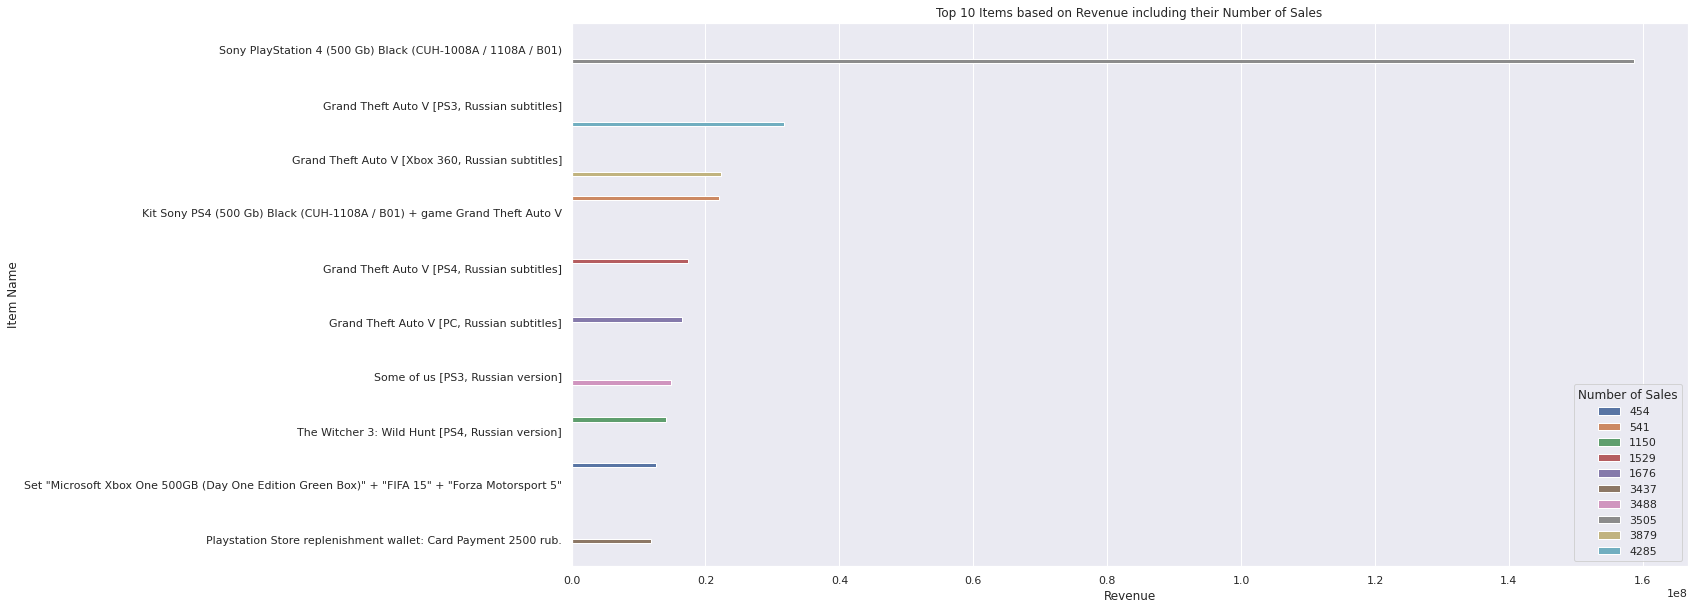

In [ ]:
# top 10 items based on their revenue
top10_revenue = item_names.nlargest(10, 'Revenue')

fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(data=top10_revenue, hue='Number of Sales', x='Revenue', y='Item Name')
plt.title("Top 10 Items based on Revenue including their Number of Sales")
plt.show()

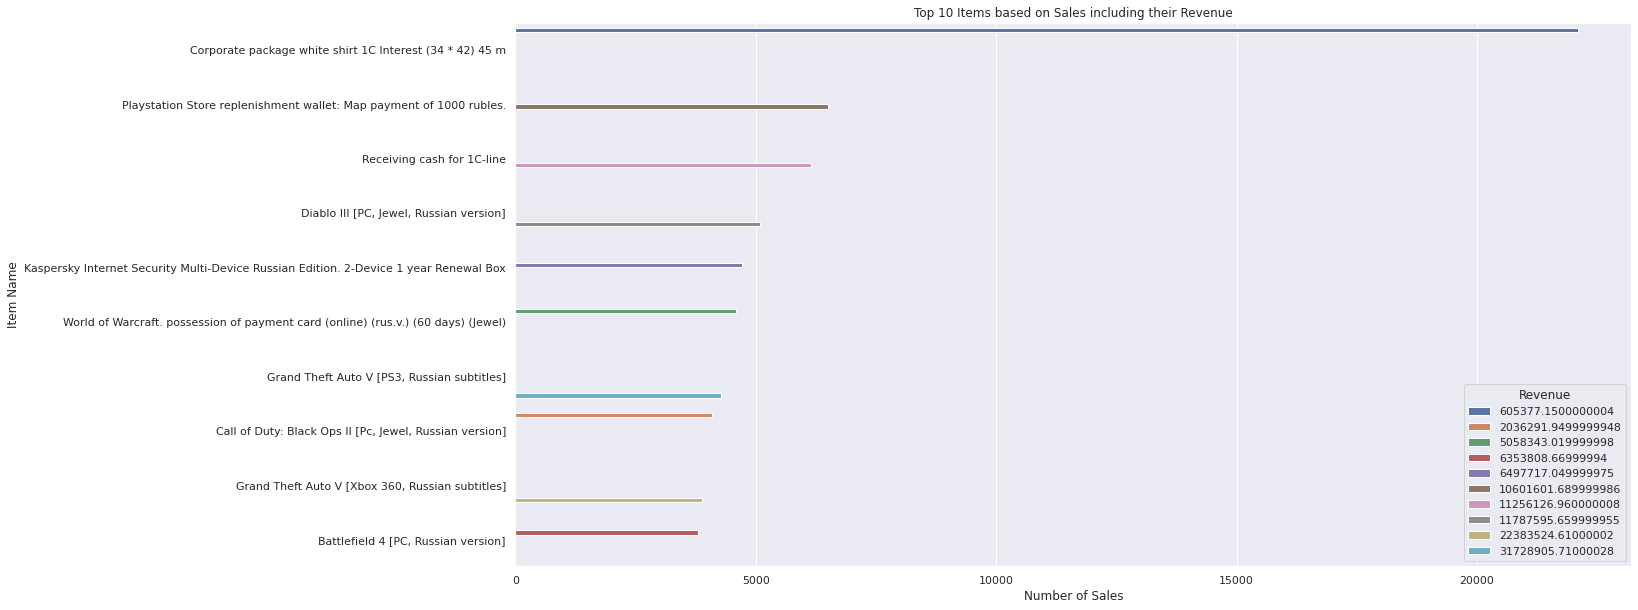

In [ ]:
# top 10 items based on their revenue
top10_sales = item_names.nlargest(10, 'Number of Sales')

fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(data=top10_sales, x='Number of Sales', y='Item Name', hue='Revenue')
plt.title("Top 10 Items based on Sales including their Revenue")
plt.show()

In [ ]:
# category names and how many items in it.
category_names = salestrain_df_combined.groupby(['item_category_name']).agg({'item_name':'count'}).reset_index().rename(columns={'item_category_name': 'Category Name','item_name': 'Number of Items'})
category_names.head()

,Category Name,Number of Items
0,Accessories - PS2,2
1,Accessories - PS3,12032
2,Accessories - PS4,17063
3,Accessories - PSP,1465
4,Accessories - PSVita,4819


In [ ]:
#Find total sales by item
total_sales_by_item = salestrain_df_combined.groupby('item_id')['item_cnt_day'].sum().reset_index()

#Sort descending
total_sales_by_item.sort_values(by='item_cnt_day',ascending=False,inplace=True)
total_sales_by_item.head()

,item_id,item_cnt_day
19895,20949,122326.0
3476,3732,12170.0
2600,2808,12120.0
16811,17717,10253.0
5446,5822,9984.0


In [ ]:
#Merge together so we can get item_name with total sales values
total_sales_by_item_with_name = total_sales_by_item.merge(items_df[['item_name','item_id']],on='item_id')
total_sales_by_item_with_name.head()

,item_id,item_cnt_day,item_name
0,20949,122326.0,Corporate package white shirt 1C Interest (34 ...
1,3732,12170.0,"Grand Theft Auto V [PS3, Russian subtitles]"
2,2808,12120.0,"Diablo III [PC, Jewel, Russian version]"
3,17717,10253.0,Receiving cash for 1C-line
4,5822,9984.0,Playstation Store replenishment wallet: Map pa...


In [ ]:
total_sales_by_item['item_cnt_day'].iloc[:10]

19895    122326.0
3476      12170.0
2600      12120.0
16811     10253.0
5446       9984.0
3478       8473.0
3475       8410.0
6239       7533.0
1708       6724.0
7346       6283.0
Name: item_cnt_day, dtype: float64

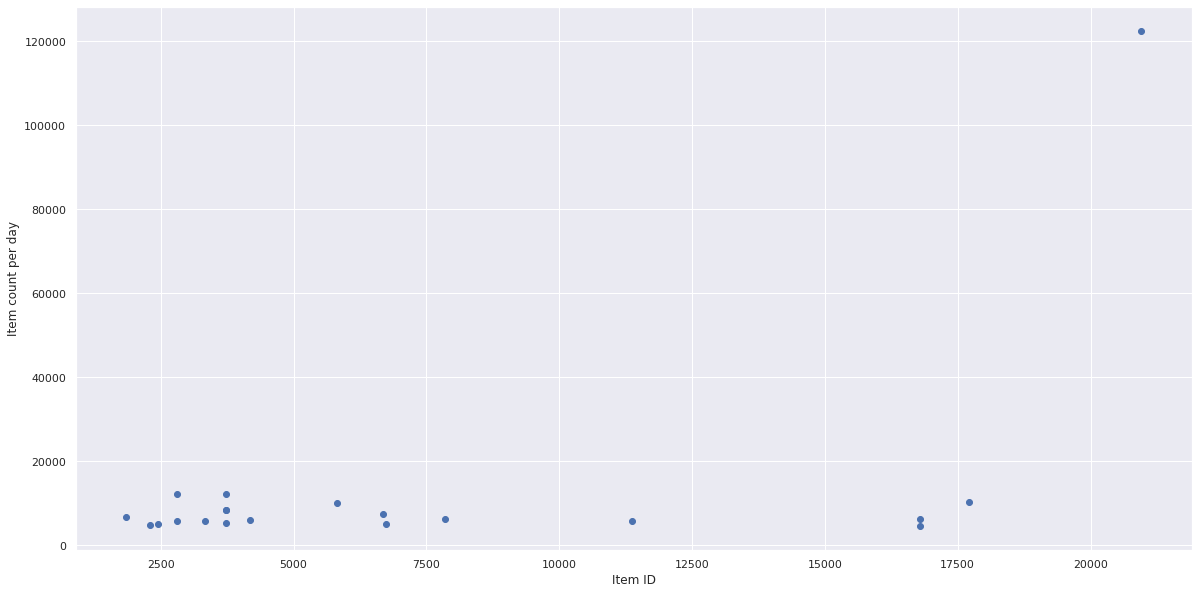

In [ ]:
# updated scatterplot showing top 20 best selling items day to day
fig, ax = plt.subplots(figsize=(20,10))
plt.scatter(y = total_sales_by_item['item_cnt_day'].iloc[:20], x = total_sales_by_item['item_id'].iloc[:20])
plt.xlabel('Item ID')
plt.ylabel('Item count per day')
plt.show()

## Recommendation Engine

In [ ]:
# Get sales by item, by date - again, not very exciting,so I also used fillna()
sales_totals_by_day = salestrain_df_combined.pivot_table(index='item_id',columns=['year', 'month', 'day'],values='item_cnt_day').fillna(0)

In [ ]:
# Clean up the multi-level index
sales_totals_by_day.columns = sales_totals_by_day.columns.droplevel().droplevel()

In [ ]:
sales_totals_by_day.head()

day,1,2,3,4,7,8,9,10,11,14,15,16,17,18,21,22,23,24,25,28,29,30,31,1,4,5,6,7,8,11,12,13,14,15,18,19,20,21,22,25,...,25,28,29,30,1,2,5,6,7,8,9,13,14,15,16,19,20,21,22,23,26,27,28,29,30,2,3,4,5,6,9,10,1,2,3,4,7,8,9,10
item_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Shape of the resulting DF - items x days
sales_totals_by_day.shape

(21059, 741)

In [ ]:
#Transpose this
sales_totals_by_day_transposed = sales_totals_by_day.transpose()

In [ ]:
sales_totals_by_day_transposed.head()

item_id,0,1,2,3,4,8,9,13,14,15,17,18,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,...,22128,22129,22130,22131,22132,22133,22134,22135,22136,22139,22140,22141,22142,22143,22144,22145,22146,22147,22148,22149,22150,22151,22152,22153,22154,22155,22156,22157,22158,22159,22160,22161,22162,22163,22164,22165,22166,22167,22168,22169
day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.166667,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.600000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.333333,1.0,1.0,1.428571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.333333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.214286,1.1,1.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.333333,1.0,1.000000,1.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.000000,1.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Recommendation engine - find the closest matches to an item in terms of daily sales
# Similar to finding similar movies based on movie rating

#Select a popular item
selected_item = 2808

In [ ]:
#Pull out the column of that day's sales
selected_item_sales = sales_totals_by_day_transposed[selected_item]

In [ ]:
#Run correlation with every other column to find similar sales patterns
similarItems = sales_totals_by_day_transposed.corrwith(selected_item_sales)

In [ ]:
#Convert from a series to a DF
similarItems_df = pd.DataFrame(similarItems)

In [ ]:
similarItems_df.head()

,0
item_id,
0,-0.006816
1,-0.018999
2,-0.010653
3,-0.007158
4,-0.010653


In [ ]:
#Rename columns
similarItems_df.columns=['similarity']

In [ ]:
similarItems_df.head()

,similarity
item_id,
0,-0.006816
1,-0.018999
2,-0.010653
3,-0.007158
4,-0.010653


In [ ]:
#Merge back item names
similarItems_df=similarItems_df.merge(items_df[['item_name','item_id']],left_index=True,right_on='item_id')

In [ ]:
#Sort
similarItems_df_sorted=similarItems_df.sort_values(by='similarity',ascending=False)

In [ ]:
#The top results for item 2808 seem to make some sense (games), but they also include programming books and other things-inconclusive?
similarItems_df_sorted.head(20)

,similarity,item_name,item_id
2808,1.000000,"Diablo III [PC, Jewel, Russian version]",2808
10956,0.527231,Django Unchained,10956
7100,0.512640,"Total War: Rome II (Pre-Order) [PC, Digital Ve...",7100
19149,0.486704,Stukachev (Paradis),19149
16900,0.465612,PARKER,16900
12571,0.463319,Fight fire,12571
13809,0.461439,LEGEND ? 17 (BD + DVD) + BD bouncer,13809
227,0.458233,1C: Audiobooks. Detectives on the road. Russia...,227
1476,0.450815,"Assassin's Creed 3. Washington [PC, Russian ve...",1476
2645,0.449823,DJ VINI Fever,2645


In [ ]:
#Function to return the values:

def find_similar_based_on_daily_sales(selected_item,sales_totals_by_day_transposed=sales_totals_by_day_transposed):
    selected_item_sales=sales_totals_by_day_transposed[selected_item]
    similarItems = sales_totals_by_day_transposed.corrwith(selected_item_sales)
    similarItems_df=pd.DataFrame(similarItems)
    similarItems_df.columns=['similarity']
    similarItems_df=similarItems_df.merge(items_df[['item_name','item_id']],left_index=True,right_on='item_id')
    similarItems_df_sorted=similarItems_df.sort_values(by='similarity',ascending=False)
    print(similarItems_df_sorted.head(20))

In [ ]:
find_similar_based_on_daily_sales(2808)

       similarity                                          item_name  item_id
2808     1.000000            Diablo III [PC, Jewel, Russian version]     2808
10956    0.527231                                   Django Unchained    10956
7100     0.512640  Total War: Rome II (Pre-Order) [PC, Digital Ve...     7100
19149    0.486704                                Stukachev (Paradis)    19149
16900    0.465612                                             PARKER    16900
12571    0.463319                                         Fight fire    12571
13809    0.461439                LEGEND ? 17 (BD + DVD) + BD bouncer    13809
227      0.458233  1C: Audiobooks. Detectives on the road. Russia...      227
1476     0.450815  Assassin's Creed 3. Washington [PC, Russian ve...     1476
2645     0.449823                                      DJ VINI Fever     2645
14429    0.448312                 MASHA AND THE BEAR. GROWTH VITAMIN    14429
4384     0.440433                           Mayndstorms LEGO NXT

In [ ]:
#What is similar to those corporate T-shirts?
find_similar_based_on_daily_sales(20949)

       similarity                                          item_name  item_id
20949    1.000000  Corporate package white shirt 1C Interest (34 ...    20949
4870     0.476556              Minecraft [Xbox 360, English version]     4870
972      0.446922        30 SECONDS TO MARS Love Lust Faith + Dreams      972
16169    0.436990  Board game Mafia whole family assembly (card g...    16169
6498     0.431264  Sims 3: Island Paradise (addition) [PC, Russia...     6498
15063    0.430087  Might and Magic. Heroes 6. The Edge of Darknes...    15063
3183     0.420700  Elder Scrolls V: Skyrim Legendary Edition [PC,...     3183
21377    0.415277         The Hobbit: An Unexpected Journey (region)    21377
8686     0.385192                                            BASTA 4     8686
21487    0.384419                      Teddy Hamster speaker (Brown)    21487
6084     0.381516              Rayman Legends [PS3, Russian version]     6084
3475     0.371692                         Fight Night Champion [

In [ ]:
#What is similar to minecraft?
find_similar_based_on_daily_sales(4870)

       similarity                                          item_name  item_id
4870     1.000000              Minecraft [Xbox 360, English version]     4870
4181     0.677028  Kaspersky Internet Security Multi-Device Russi...     4181
4178     0.631802  Kaspersky Internet Security Multi-Device Russi...     4178
3423     0.540385   Far Cry 3 (Classics) [Xbox 360, Russian version]     3423
10659    0.516131  Puzzle Rubik's Cube 3x3 without labels, soft m...    10659
21377    0.502177         The Hobbit: An Unexpected Journey (region)    21377
4904     0.501229  Mortal Kombat. Komplete Edition [PC, Jewel, Ru...     4904
10292    0.489980                                      DESPICABLE ME    10292
6498     0.487813  Sims 3: Island Paradise (addition) [PC, Russia...     6498
20949    0.476556  Corporate package white shirt 1C Interest (34 ...    20949
3183     0.475203  Elder Scrolls V: Skyrim Legendary Edition [PC,...     3183
16056    0.470798            Table game World of Tanks Rush art.

In [ ]:
#This item averaged 5 sales per day, max of 35, so it wasn't distorted by one overwhelmingly high corporate order
sales_totals_by_day_transposed[20949].describe()

count    741.000000
mean       4.736694
std        2.900007
min        0.000000
25%        3.594595
50%        4.500000
75%        5.875000
max       24.750000
Name: 20949, dtype: float64

## Rolling window K-fold cross-validation

In [ ]:
salestrain_df_combined.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'USD_RUS', 'USD_Price', 'year', 'item_name',
       'item_category_id', 'item_category_name', 'shop_name', 'month', 'day',
       'revenue', 'month-year', 'Random'],
      dtype='object')

In [ ]:
# setting X as date col and y as revenue col to be split
X = salestrain_df_combined['date']
y = salestrain_df_combined['revenue']

In [ ]:
# creating the time series split, one split for every month in the year
tscv = TimeSeriesSplit(n_splits = 12)

In [ ]:
# looping through every time series split 
for train_index, test_index in tscv.split(X):
  print(f'TRAIN SHAPE: {train_index.shape} TEST SHAPE: {test_index.shape}')
    
  #X_train, X_test = X[train_index], X[test_index]
  #y_train, y_test = y[train_index], y[train_index]

TRAIN SHAPE: (148238,) TEST SHAPE: (148236,)
TRAIN SHAPE: (296474,) TEST SHAPE: (148236,)
TRAIN SHAPE: (444710,) TEST SHAPE: (148236,)
TRAIN SHAPE: (592946,) TEST SHAPE: (148236,)
TRAIN SHAPE: (741182,) TEST SHAPE: (148236,)
TRAIN SHAPE: (889418,) TEST SHAPE: (148236,)
TRAIN SHAPE: (1037654,) TEST SHAPE: (148236,)
TRAIN SHAPE: (1185890,) TEST SHAPE: (148236,)
TRAIN SHAPE: (1334126,) TEST SHAPE: (148236,)
TRAIN SHAPE: (1482362,) TEST SHAPE: (148236,)
TRAIN SHAPE: (1630598,) TEST SHAPE: (148236,)
TRAIN SHAPE: (1778834,) TEST SHAPE: (148236,)


## Removing features with low variance

In [ ]:
salestrain_df_combined.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'USD_RUS', 'USD_Price', 'year', 'item_name',
       'item_category_id', 'item_category_name', 'shop_name', 'month', 'day',
       'revenue', 'month-year', 'Random'],
      dtype='object')

In [ ]:
train_set = salestrain_df_combined.drop(columns = ['revenue'])

In [ ]:
# mapping date col to ordinal for use with VarianceThreshold
train_set['date'] = train_set['date'].map(dt.datetime.toordinal)

In [ ]:
for col in ['item_name', 'item_category_name', 'shop_name']:
   train_set[col] = LabelEncoder().fit_transform(train_set[col])

In [ ]:
test_set = salestrain_df_combined['revenue']

In [ ]:
train_set.dtypes

date                    int64
date_block_num          int64
shop_id                 int64
item_id                 int64
item_price            float64
item_cnt_day            int16
USD_RUS               float64
USD_Price             float64
year                    int64
item_name               int64
item_category_id        int64
item_category_name      int64
shop_name               int64
month                   int64
day                     int64
month-year             object
Random                  int64
dtype: object

In [ ]:
test_set.shape

(1927070,)

In [ ]:
# creating the Variance Threshold and setting variance to 10 -> can mess around with this number
threshold = VarianceThreshold(threshold = 10)

In [ ]:
# fit transforming variance threshold to train set
high_variance = threshold.fit(train_set)

ValueError: ignored

In [ ]:
# seeing which cols do not have high variance
train_set.columns[high_variance.get_support()]

In [ ]:
# seeing which cols have low variance
constant_cols = [column for column in train_set.columns if column not in train_set.columns[high_variance.get_support()]]
print(f'The columns with low(ish) variance is: {constant_cols}')

All of our features have high variance, therefore they don't have to be removed.

## K-Means clustering

In [ ]:
#salestrain_df.head()
salestrain_df = salestrain_df.drop('date', axis=1)

In [ ]:
salestrain_df.head(10)

In [ ]:
# Create scaler: scaler
scaler = StandardScaler()

# Create KMeans instance: kmeans
kmeans = KMeans(n_clusters=4)

# Create pipeline: pipeline
pipeline = make_pipeline(scaler, kmeans)

# Fit the pipeline to samples
pipeline.fit(np.array(salestrain_df))

# Calculate the cluster labels: labels
labels = pipeline.predict(salestrain_df)

# Create a DataFrame with labels and prices as columns: salestrain_df
#salestrain_df = pd.DataFrame({'item_price': item_price, 'item_cnt_day': item_cnt_day})

# Create crosstab: ct
ct = pd.crosstab(salestrain_df['item_price'], salestrain_df['item_cnt_day'])

# Display ct
print(ct.sort_values('item_price'))

In [ ]:
# plotting clusters
plt.figure(figsize=(20, 10))
plt.plot(ct)
plt.show()

In [ ]:
# reshaping values to workable vector
dfx = salestrain_df.values.reshape(1, -1)
dfy = salestrain_df.values.reshape(1, -1)

In [ ]:
# WHY DELETING?

# delete part 1
#dfx = np.delete(dfx, 0)
#dfy = np.delete(dfy, 0)

In [ ]:
# WHY DELETING?

# delete part 2
#dfx = np.delete(dfx, 1)
#dfy = np.delete(dfy, 1)

In [ ]:
print(f'dfx shape: {dfx.shape}')
print(f'dfy shape: {dfy.shape}')

In [ ]:
# setting variables train test split
X = dfx
y = dfy

# running logistic regression baseline
#logreg =  LogisticRegression()
#X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# checking train, test shapes
#print(f'X_train shape: {X_train.shape}')
#print(f'y_train shape: {y_train.shape}')
#print(f'X_test shape: {X_test.shape}')
#print(f'y_test shape: {y_test.shape}')

In [ ]:
#
#logreg.fit(X_train, y_train)
#y_pred =logreg.predict(X_test)

#print(confusion_matrix(y_test, y_pred))
#print(classification_report(y_test, y_pred))

In [ ]:
#clf = linear_model.Lasso(alpha=0.1)
#clf.fit(X_train, y_train)
#clf.predict(X_test)
#print(confusion_matrix(y_test, y_pred))
#print(classification_report(y_test, y_pred))

## Categorical features
Created different datasets with OHE encoding, mean/target encoding, frequency encoding and hash encoding

#### OHE
OHE does not work, memory issue due to the fact that there are 22150 unique item names.

In [ ]:
# item_name unique 22150 values --> colossal number of columns, not the best option since shape will be (2935846, 21787)
cols_to_encode = ['item_category_name', 'shop_name']
salestrain_df_ohe = salestrain_df_combined.copy()

# change float64 to float16 and int64 to int16 to reduce memory usage
salestrain_df_ohe['item_price'] = salestrain_df_ohe['item_price'].astype(np.float16)
cols_int = salestrain_df_ohe.select_dtypes('int64').columns
for col in cols_int:
    salestrain_df_ohe[col] = salestrain_df_ohe[col].astype(np.int16)

# OHE
salestrain_df_ohe = pd.get_dummies(salestrain_df_ohe, prefix=['item_category_name', 'shop_name'], columns=['item_category_name', 'shop_name'], dtype=np.int16)

# renaming
item_cat_iter = 0
shop_iter = 0
for col in salestrain_df_ohe.columns:
    if col.startswith('item_category_name_'):
        salestrain_df_ohe.rename(columns={col: "item_category_name_" + str(item_cat_iter)}, inplace=True)
        item_cat_iter += 1
    if col.startswith('shop_name_'):
        salestrain_df_ohe.rename(columns={col: "shop_name_" + str(shop_iter)}, inplace=True)
        shop_iter += 1

# sounds good doesn't work: too many different categories for item_name
# cols_to_encode = ['item_name', 'item_category_name', 'shop_name']
# for col in cols_to_encode:
#     salestrain_df_ohe = pd.get_dummies(salestrain_df_ohe, prefix=[col], columns=[col])
#     ohe_enc = OneHotEncoder()
#     ohe_enc = ohe_enc.fit_transform(salestrain_df_ohe[[col]]).astype(np.int16).toarray()
#     encoded_cols = pd.DataFrame(ohe_enc)
#     salestrain_df_ohe = pd.concat([salestrain_df_ohe, encoded_cols], axis = 1)
    
salestrain_df_ohe.head()

#### Frequency encoder
Set categorical features to frequency they occur in the dataset

In [ ]:
cols_to_encode = ['item_name', 'item_category_name', 'shop_name']
salestrain_df_freq = salestrain_df_combined.copy()

# grouping by frequency
for col in cols_to_encode:
    freq = salestrain_df_freq.groupby(col).size()/len(salestrain_df_freq)
    salestrain_df_freq.loc[:, "{}_freq_encode".format(col)] = salestrain_df_freq[col].map(freq)
    
salestrain_df_freq.drop(columns=cols_to_encode, inplace=True)
salestrain_df_freq.head()

#### Hashing
Use hash functions to translate categorical feature to numeric features



The values itself don't really say anything tbh, but the combination of the columns are mapped to one value within the original categorical feature
So for example, if you would have a categorical feature, the hash function maps this string to an X number of integers

In [ ]:
# currently, number of bits used to represent features is a bit random (2^x where the result is bigger than number of unique values)
# this takes quite a bit of time to run
cols_to_encode = ['item_name', 'item_category_name', 'shop_name']
nr_bits = [6, 7, 15]
salestrain_df_hash = salestrain_df_combined.copy()

for bits, col in zip(nr_bits, cols_to_encode):
    print(bits, col)
    h = FeatureHasher(n_features=bits, input_type='string') 
    hashed_col = h.fit_transform(salestrain_df_hash[col].astype(str)).toarray()
    salestrain_df_hash = pd.concat([salestrain_df_hash, pd.DataFrame(hashed_col)], axis = 1)
    for i in range(bits):
        salestrain_df_hash.rename(columns={i: col + "_" + str(i)}, inplace=True)
    print(col + " done")
        
salestrain_df_hash.head()

#### Target/mean encoding
Seems to work very well in lots of applications, but can cause overfitting. Maybe use (stratified) KFold?

In [ ]:
cols_to_encode = ['item_name', 'item_category_name', 'shop_name']
salestrain_df_mean = salestrain_df_combined.copy()

# simple method, probably should do this with item_cnt_month though, should create that feature
for col in cols_to_encode:
    mean_enc = salestrain_df_mean.groupby(col)['item_cnt_day'].mean()
    salestrain_df_mean.loc[:, str(col + "_mean_encoded")] = salestrain_df_mean[col].map(mean_enc)
    
salestrain_df_mean.head()

# DBSCAN (and other clustering)


In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
# creating DBSCAN data copy
salestrain_DBSCAN = salestrain_df_combined.copy()
X = salestrain_DBSCAN['date']
y = salestrain_DBSCAN['revenue']


salestrain_DBSCAN = salestrain_DBSCAN.drop(columns=['date'])

In [ ]:
# showing sales pre clustering
plt.figure(figsize=(20,10))
plt.scatter(X, y, s=15, color='grey')
plt.show()

TRY CLUSTERING PART 2 WITH MITCHELLS CATEGORICAL HASHING 

In [ ]:
#salestrain_df_hash.head()
salestrin_DBSCAN = salestrain_df_hash.drop(columns=['date', 'item_name', 'item_category_name','shop_name'], axis=1)
salestrain_DBSCAN.head()

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(salestrain_DBSCAN)

In [ ]:
k_means = KMeans(n_clusters=4, random_state=42)
k_means.fit(salestrain_DBSCAN[0,1])

need to determine 2 things with DBSCAN, epsilon and minPoints

## LSTM

Some Random Forest and LSTM (followed somewhere but no really understand the whole thing). Open work, feel free to engage.

In [ ]:
# made a copy of our Master train data for trial model application
data = salestrain_df_combined.copy()
datatrain = data.pivot_table(index = ['shop_id', 'item_id'], values = ['item_cnt_day'], columns = ['date_block_num'], fill_value = 0, aggfunc = 'sum')
datatrain.reset_index(inplace = True)
datatrain

shop_id item_id item_cnt_day               ...                     
date_block_num                            0   1  2  3  4  ... 27 28 29 30 31 32 33
0                    0      30            0  15  0  0  0  ...  0  0  0  0  0  0  0
1                    0      31            0   6  0  0  0  ...  0  0  0  0  0  0  0
2                    0      32            6   7  0  0  0  ...  0  0  0  0  0  0  0
3                    0      33            3   3  0  0  0  ...  0  0  0  0  0  0  0
4                    0      35            1   8  0  0  0  ...  0  0  0  0  0  0  0
...                ...     ...          ...  .. .. .. ..  ... .. .. .. .. .. .. ..
370236              59   22154            1   0  0  0  0  ...  0  0  0  0  0  0  0
370237              59   22155            0   0  0  0  0  ...  0  0  0  0  0  0  0
370238              59   22162            0   0  0  0  0  ...  1  1  0  0  0  0  0
370239              59   22164            0   0  0  0  0  ...  2  0  0  1  0  0  0
370240              59   22167            0   0  0  0  0  ...  0  0  0  0  0  0  0

[370241 rows x 36 columns]

In [ ]:
# make a copy of test data from the uploaded files
datatest = test_df.copy()

# remove ID column, not relevant
datatest = datatest.drop(['ID'], axis=1)
datatest

,shop_id,item_id
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268
...,...,...
214195,45,18454
214196,45,16188
214197,45,15757
214198,45,19648


In [ ]:
# merge data train set to our test set
dataset = pd.merge(datatest, datatrain, on=['item_id', 'shop_id'], how='left')

# fill NaN values with 0 
dataset.fillna(0, inplace=True)

# drop shop_id and item_id columns for train_test_split
dataset.drop(['shop_id', 'item_id'], inplace=True, axis=1)
dataset

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)","(item_cnt_day, 7)","(item_cnt_day, 8)","(item_cnt_day, 9)","(item_cnt_day, 10)","(item_cnt_day, 11)","(item_cnt_day, 12)","(item_cnt_day, 13)","(item_cnt_day, 14)","(item_cnt_day, 15)","(item_cnt_day, 16)","(item_cnt_day, 17)","(item_cnt_day, 18)","(item_cnt_day, 19)","(item_cnt_day, 20)","(item_cnt_day, 21)","(item_cnt_day, 22)","(item_cnt_day, 23)","(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,3.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
214196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214197,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# labeling our data
X = dataset.values[:, :-1]
y = dataset.values[:, -1:]
test = dataset.values[:, 1:]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = dataset.values[:, 1:]

MM_scaler = MinMaxScaler()
X_train = MM_scaler.fit_transform(X_train)
X_valid = MM_scaler.transform(X_valid)
X_test = MM_scaler.transform(X_test)

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, test.shape)

(171360, 33, 1) (171360, 1) (42840, 33, 1) (42840, 1) (214200, 33, 1) (214200, 33)


In [ ]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

model = keras.models.Sequential([
    keras.layers.LSTM(30, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(30, return_sequences=True),
    keras.layers.LSTM(30),
    keras.layers.Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
              loss = 'mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

early_stopping = EarlyStopping(
    patience=5, # how many epochs to wait before stopping
    monitor='val_rmse', 
    mode='min',
    restore_best_weights=True,
)

reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_rmse', 
    factor=0.8, 
    patience=2, 
    mode='auto', 
    cooldown=3,
    min_lr=0.00001
)

model.summary()

history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid),
                    callbacks = [early_stopping, reduceLROnPlat])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, None, 30)          3840      
_________________________________________________________________
lstm_16 (LSTM)               (None, None, 30)          7320      
_________________________________________________________________
lstm_17 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 31        
Total params: 18,511
Trainable params: 18,511
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
5355/5355 [==============================] - 44s 8ms/step - loss: 5.7363 - rmse: 2.3626 - val_loss: 1.3148 - val_rmse: 1.1467
Epoch 2/5
5355/5355 [==============================] - 41s 8ms/step - loss: 3.6267 - rmse: 1.8397 - val_loss: 1.

In [ ]:
prediction = model.predict(X_test)
prediction = prediction.clip(0, 20)
prediction

array([[0.2811672 ],
       [0.10283363],
       [0.42656168],
       ...,
       [0.09461117],
       [0.10283363],
       [0.0916822 ]], dtype=float32)

Random Forest Regressor

In [ ]:
RFR = AdaBoostRegressor(base_estimator = RandomForestRegressor(max_depth = 10), random_state = 0, n_estimators = 3000)
RFR.fit(X, y)
y_pred = RFR.predict(X)
y_pred

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0.53573347, 0.09925319, 0.68133568, ..., 0.09925319, 0.09925319,
       0.09925319])

In [ ]:
print(RFR.score(X, y))

0.6937374891874816


In [ ]:
pred = model.predict(X_test)
pred

array([[0.1890904 ],
       [0.07642972],
       [0.14988828],
       ...,
       [0.05848101],
       [0.07642972],
       [0.05156094]], dtype=float32)


# good resources

dbscan!

https://www.google.com/search?q=dbscan+python&sxsrf=ALeKk01MOpqS6o2Y-gJotJVswEPIS6thPA%3A1616814191706&ei=b6BeYL68KsKHggfYxrfgDw&oq=dbscan&gs_lcp=Cgdnd3Mtd2l6EAMYAjIECCMQJzIECAAQQzIECAAQQzIECAAQQzIECAAQQzIECAAQQzIHCAAQsQMQQzICCAAyBAgAEEMyAggAOgoILhDHARCvARBDOgoILhDHARCjAhBDOggILhCxAxCDAToNCC4QsQMQxwEQowIQQzoKCAAQsQMQgwEQQ1DFalilcmDHiwFoAHACeACAAdYLiAHZFZIBDTAuNC4xLjUtMS4wLjGYAQCgAQGqAQdnd3Mtd2l6wAEB&sclient=gws-wiz

https://www.kdnuggets.com/2020/04/dbscan-clustering-algorithm-machine-learning.html

https://www.geeksforgeeks.org/implementing-dbscan-algorithm-using-sklearn/

https://www.analyticsvidhya.com/blog/2020/09/how-dbscan-clustering-works/

aws colab integration

https://medium.com/@lily_su/accessing-s3-bucket-from-google-colab-16f7ee6c5b51

https://python.plainenglish.io/how-to-load-data-from-aws-s3-into-google-colab-7e76fbf534d2

https://stackoverflow.com/questions/50978361/how-to-load-s3-open-dataset-in-google-colaboratory